In [1]:
import argparse
import sys, os
sys.path.append(os.path.join(sys.path[0], '/home/nazar/PycharmProjects/brule2/src/'))
sys.path.append(os.path.join(sys.path[0], '/home/nazar/PycharmProjects/brule2/src/gans_pytorch/'))
sys.path.append(os.path.join(sys.path[0], '/home/nazar/PycharmProjects/brule2/src/gans_pytorch/stylegan2'))
sys.path.append(os.path.join(sys.path[0], '/home/nazar/PycharmProjects/brule2/src/gans_pytorch/gan/'))

from dataset.lazy_loader import LazyLoader, W300DatasetLoader, CelebaWithKeyPoints, Celeba

In [2]:
from dataset.probmeasure import ProbabilityMeasureFabric, ProbabilityMeasure, UniformMeasure2DFactory, \
UniformMeasure2D01
from torch import nn

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [7]:
# from dataset.cardio_dataset import ImageMeasureDataset
# from dataset.probmeasure import ProbabilityMeasure, ProbabilityMeasureFabric
# from geomloss import SamplesLoss

In [8]:
# import torch
# device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
# print(device)
# torch.cuda.set_device(device)

In [8]:
def imgs_with_mask(imgs, mask, color=[1.0,1.0,1.0]):
    # mask = torch.cat([mask, mask, mask], dim=1)
    mask = mask[:, 0, :, :]
    res: Tensor = imgs.cpu().detach()
    res = res.permute(0, 2, 3, 1)
    res[mask > 0.00001, :] = torch.tensor(color, dtype=torch.float32)
    res = res.permute(0, 3, 1, 2)
    return res

In [8]:
g_transforms: albumentations.DualTransform = albumentations.Compose([
        MeasureToMask(size=256),
        ToNumpy(),
        NumpyBatch(albumentations.ElasticTransform(p=1, alpha=150, alpha_affine=1, sigma=10)),
        NumpyBatch(albumentations.ShiftScaleRotate(p=1, rotate_limit=10)),
        ToTensor(device),
        MaskToMeasure(size=256, padding=140),
    ])

In [9]:
class Samples_Loss(nn.Module):
    def __init__(self, blur=.01, scaling=.9, diameter=None, border=None, p: int = 2):
        super(Samples_Loss, self).__init__()
        self.border = border
        self.loss = SamplesLoss("sinkhorn", blur=blur, scaling=scaling, debias=False, diameter=diameter, p=p)
        # self.pot = SamplesLoss("sinkhorn", blur=blur, scaling=scaling, debias=False, potentials=True)

    def forward(self, m1: ProbabilityMeasure, m2: ProbabilityMeasure):
        batch_loss = self.loss(m1.probability, m1.coord, m2.probability, m2.coord)
        return batch_loss


In [10]:
def handmadew1(m1,m2):
    lambd = 0.002
    with torch.no_grad():
        P = SOT(200, lambd).forward(m1, m2)
        print("RAVNOMERNAYA MERA", P[0])
        M = PairwiseDistance()(m1.coord, m2.coord).sqrt()
        print("L2 cherez PAIRWISE: " , M[0, 10,20])
        print("L2 v ruchnuu: ", (m1.coord[0, 10] - m2.coord[0, 20]).pow(2).sum().sqrt())
    return (M * P).sum(dim=(1,2)) / 2 # (2 * m1.coord.shape[1])

In [4]:
from dataset.toheatmap import ToGaussHeatMap
from dataset.probmeasure import UniformMeasure2D01
heatmaper = ToGaussHeatMap(64, 1.5)

In [5]:
LazyLoader.w300_save = None
W300DatasetLoader.batch_size = 1

In [6]:
import torch

In [71]:
kapusta = torch.zeros(64,64)
for i in range(10):
    w300_train = next(iter(LazyLoader.w300().loader_train_inf))
    w300_train_image = w300_train['data'][:8]
    keyptsiki = w300_train['meta']['keypts_normalized']
    tmp = heatmaper.forward(keyptsiki)
    kapusta += tmp.sum(axis=(0,1))
    print(keyptsiki[0,:,0].sum(), keyptsiki[0,:,1].sum())
    
# plt.imshow((w300_train_image[0].permute(1,2,0)+ 1) / 2)

tensor(34.2882) tensor(37.6390)
tensor(34.3911) tensor(38.3318)
tensor(25.7030) tensor(38.1343)
tensor(37.4310) tensor(38.2738)
tensor(32.4963) tensor(37.9209)
tensor(25.9525) tensor(37.9182)
tensor(38.3671) tensor(37.3962)
tensor(29.5012) tensor(38.7408)
tensor(35.2238) tensor(38.0063)
tensor(41.1223) tensor(36.4349)


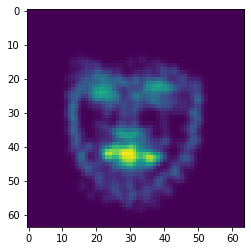

In [66]:
plt.imshow(kapusta)

In [7]:
from sklearn.neighbors import NearestNeighbors

In [30]:
# %%time

# N = 100
# D = np.zeros((N, N))
# a = np.ones(68) / 68

# for i in tqdm(range(N)):
#     for j in range(i+1, N):
#         M_ij = ot.dist(LazyLoader.w300().dataset_train[i]['meta']['keypts_normalized'],
#                        LazyLoader.w300().dataset_train[j]['meta']['keypts_normalized'])        
#         D[i,j] = ot.emd2(a, a, M_ij)
        
# D = np.sqrt(D + D.T)
# D

In [18]:
import ot
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [25]:
from joblib import Parallel, delayed


In [28]:
def processInput(i, j):
    M_ij = ot.dist(LazyLoader.w300().dataset_train[i]['meta']['keypts_normalized'],
                       LazyLoader.w300().dataset_train[j]['meta']['keypts_normalized'])        
    D[i,j] = ot.emd2(a, a, M_ij)
    return D[i, j]

In [35]:
%%time

N = 100
D = np.zeros((N, N))
a = np.ones(68) / 68
num_cores = 10

for i in tqdm(range(N)):
    D[i, i+1:] = np.array(Parallel(n_jobs=num_cores)(delayed(processInput)(i, j) for j in range(i+1, N)))
D = np.sqrt(D + D.T)
D

/home/ibespalov/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



CPU times: user 10.4 s, sys: 577 ms, total: 10.9 s
Wall time: 1min 31s


array([[0.        , 0.04002456, 0.06941386, ..., 0.07935266, 0.04078202,
        0.14284078],
       [0.04002456, 0.        , 0.04069154, ..., 0.10170789, 0.05402638,
        0.10530641],
       [0.06941386, 0.04069154, 0.        , ..., 0.13760085, 0.03348013,
        0.09804267],
       ...,
       [0.07935266, 0.10170789, 0.13760085, ..., 0.        , 0.09452776,
        0.21137319],
       [0.04078202, 0.05402638, 0.03348013, ..., 0.09452776, 0.        ,
        0.12333243],
       [0.14284078, 0.10530641, 0.09804267, ..., 0.21137319, 0.12333243,
        0.        ]])

In [36]:
nbrs = NearestNeighbors(n_neighbors=10, metric="precomputed").fit(D)
distances, indices = nbrs.kneighbors(D)

In [39]:
X_init = np.random.uniform(size=(68, 2))

In [40]:
weights = np.array([0.1] * 10)
weights

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [51]:
def LS(k):
    return LazyLoader.w300().dataset_train[k]['meta']['keypts_normalized'].numpy()


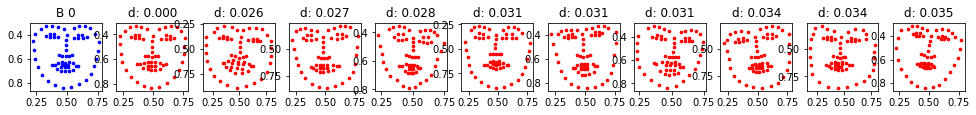

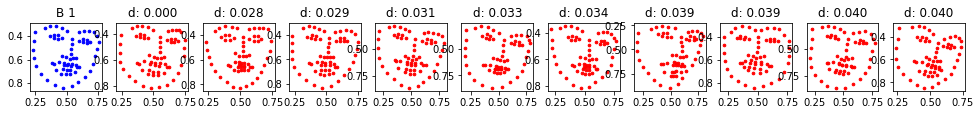

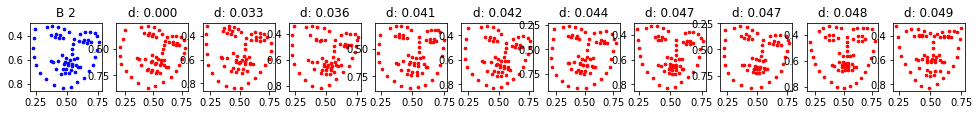

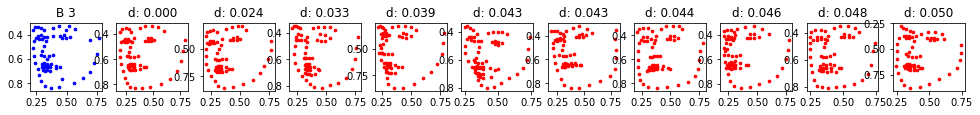

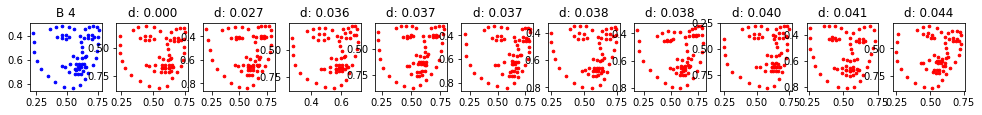

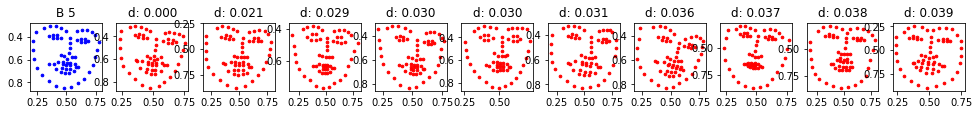

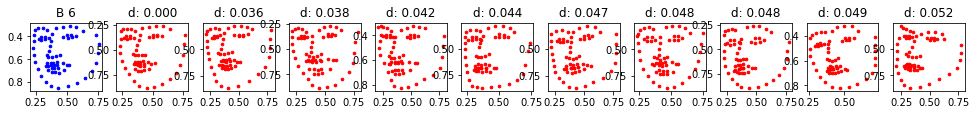

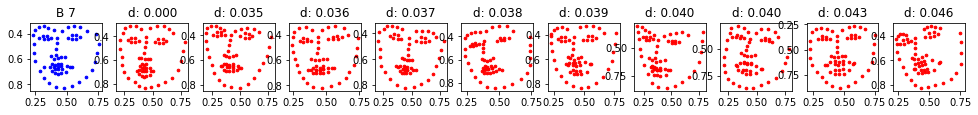

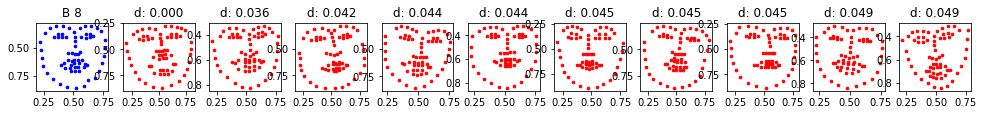

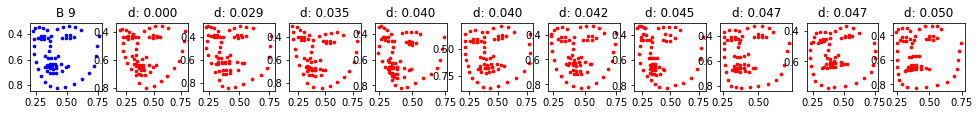

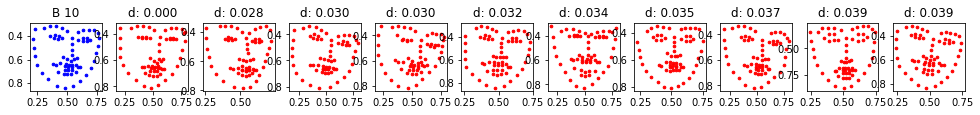

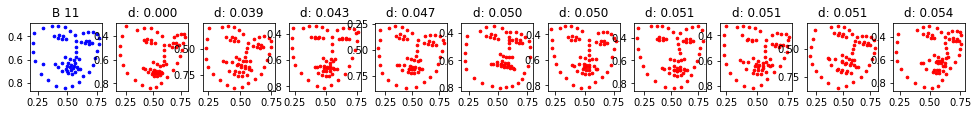

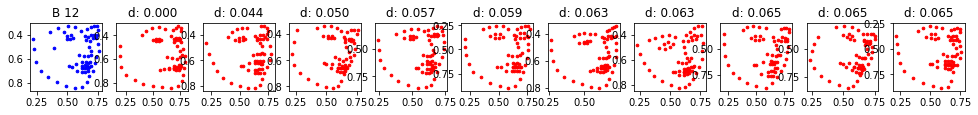

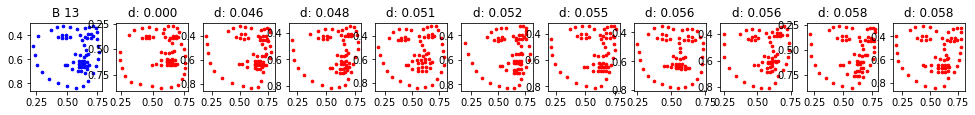

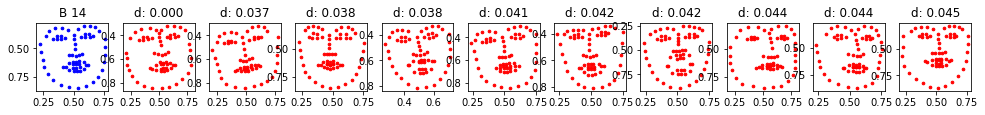

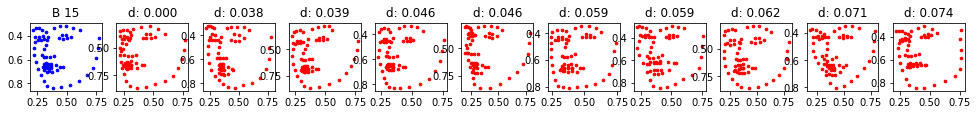

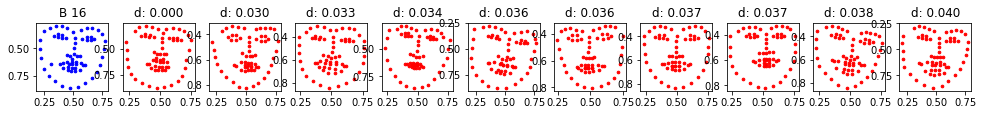

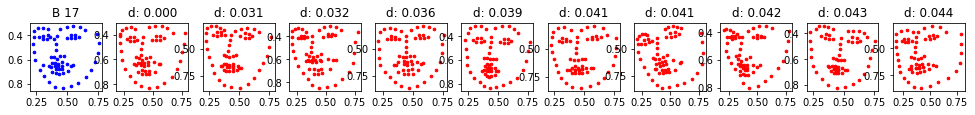

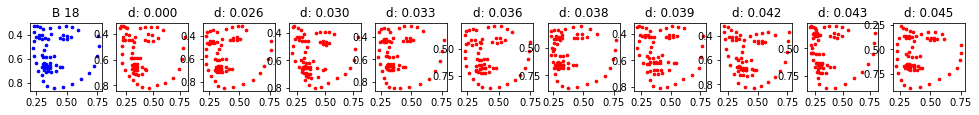

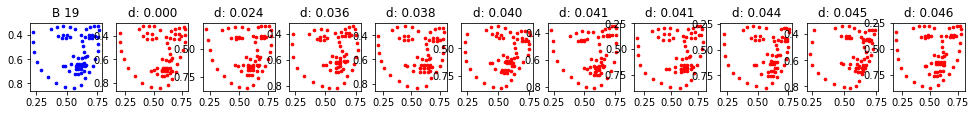

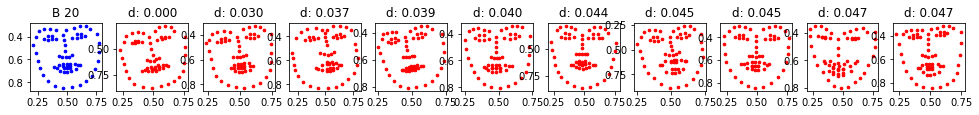

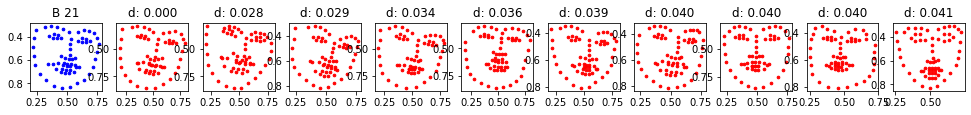

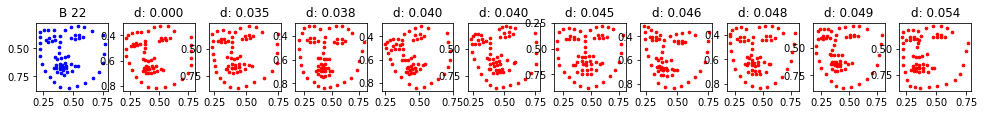

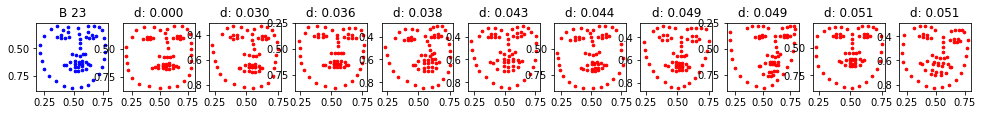

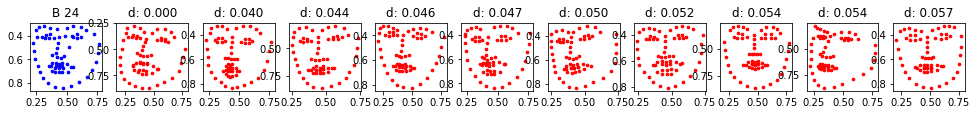

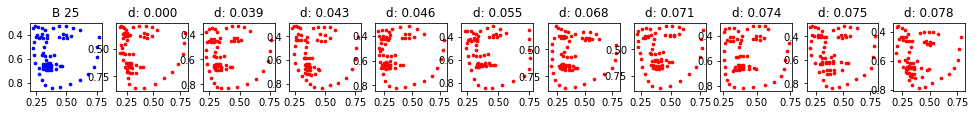

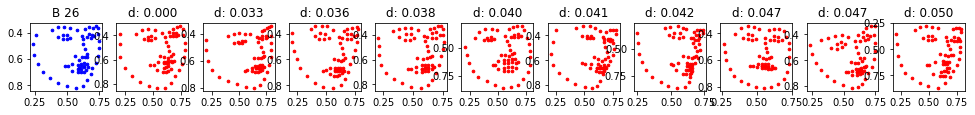

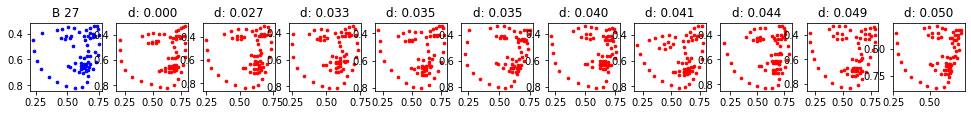

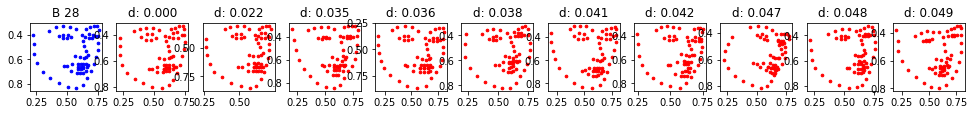

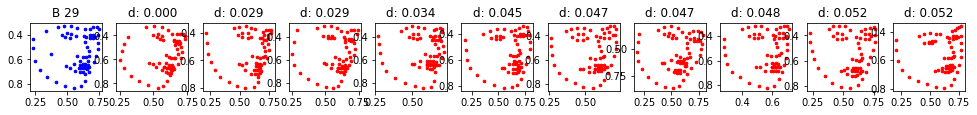

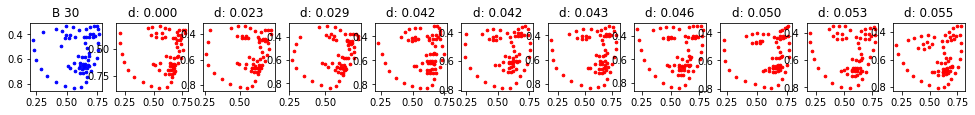

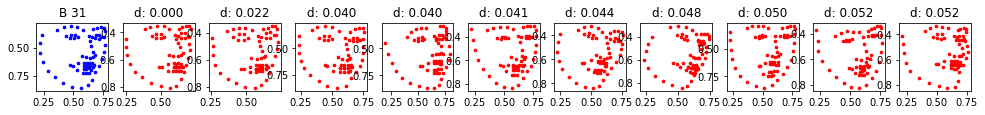

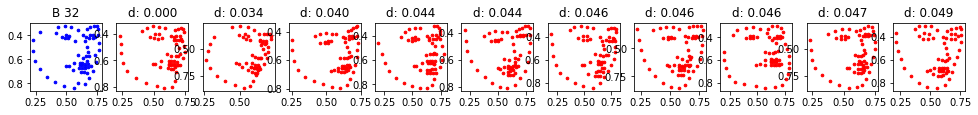

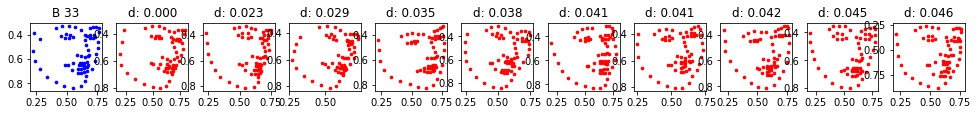

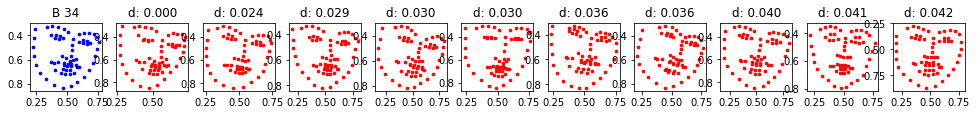

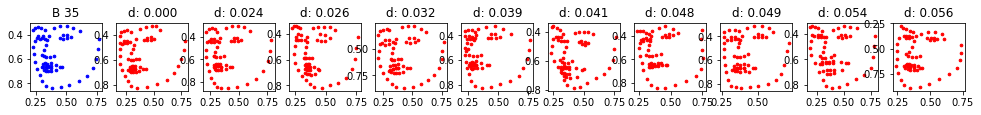

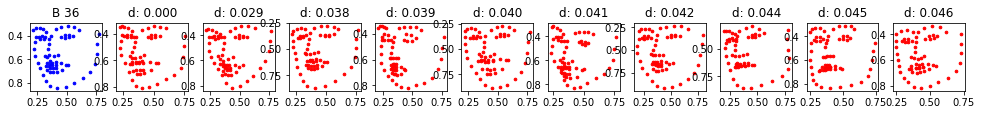

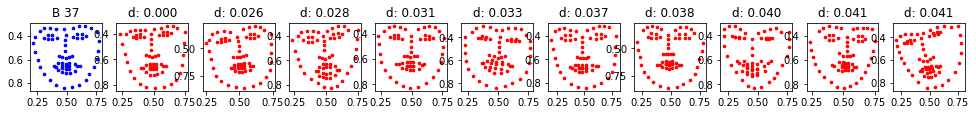

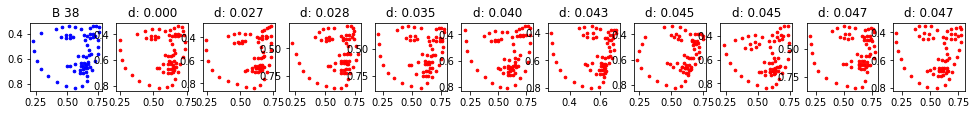

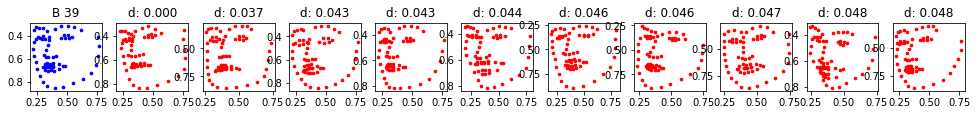

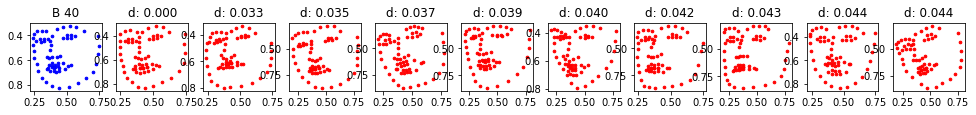

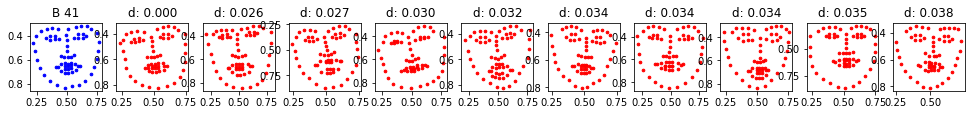

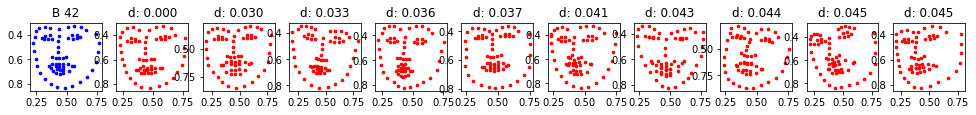

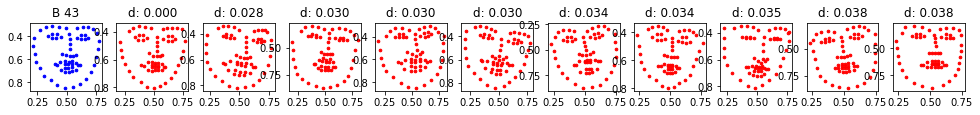

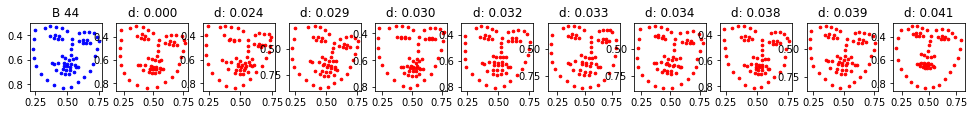

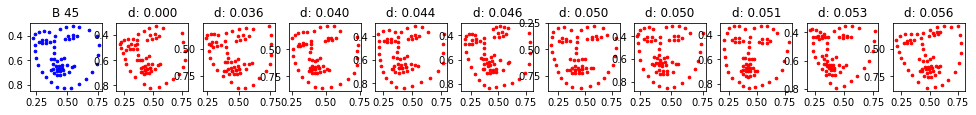

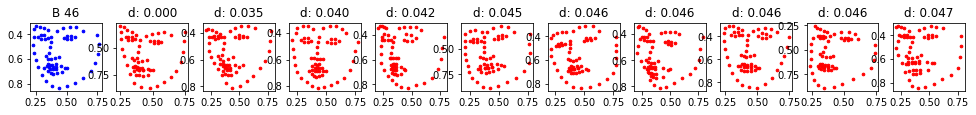

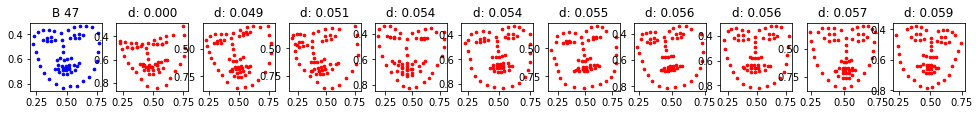

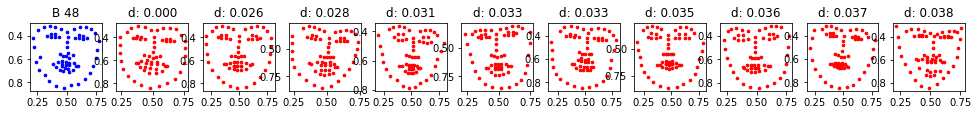

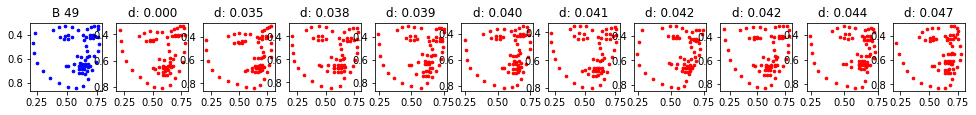

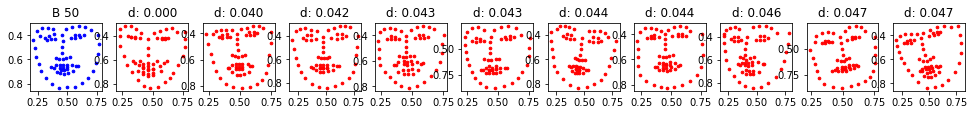

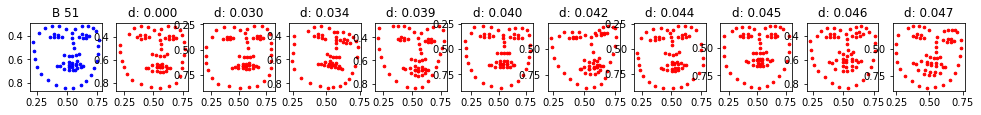

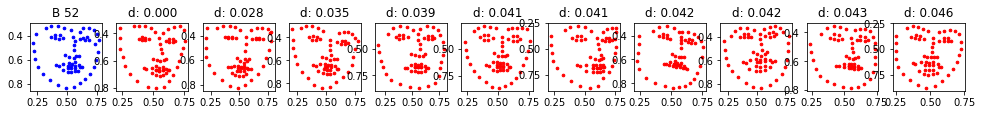

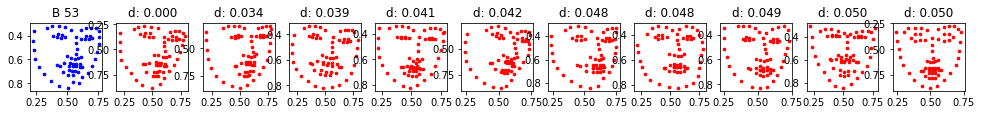

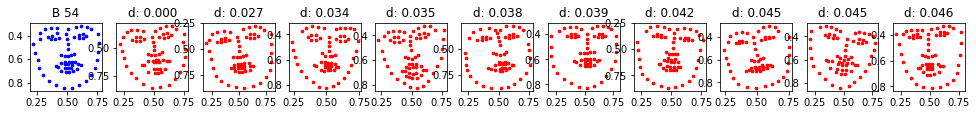

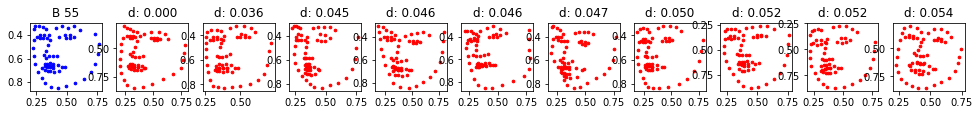

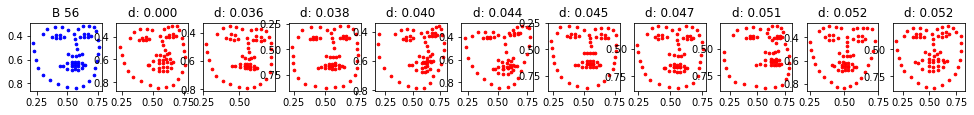

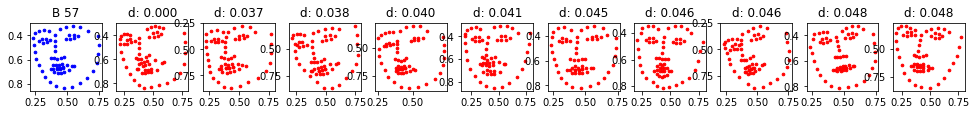

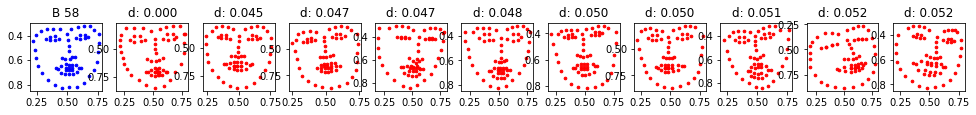

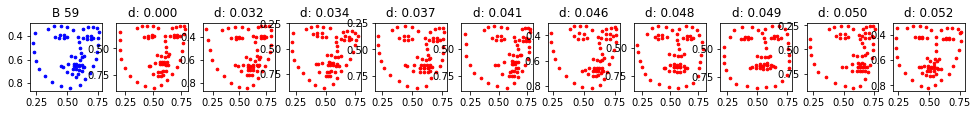

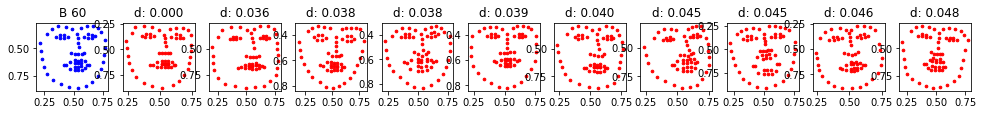

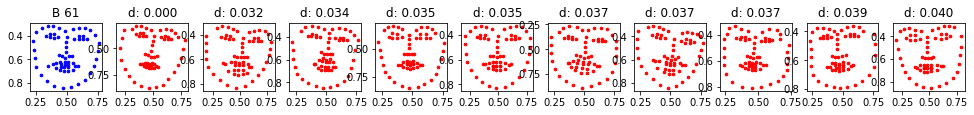

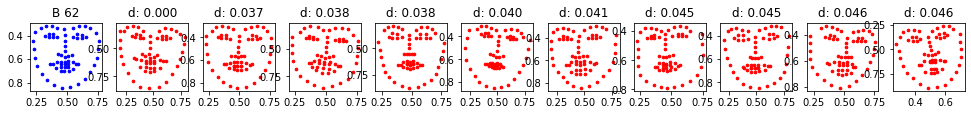

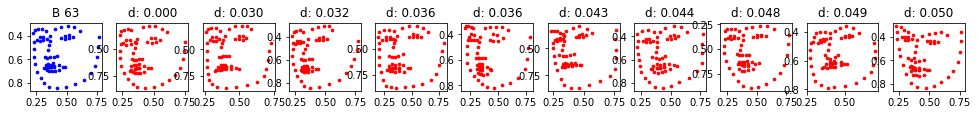

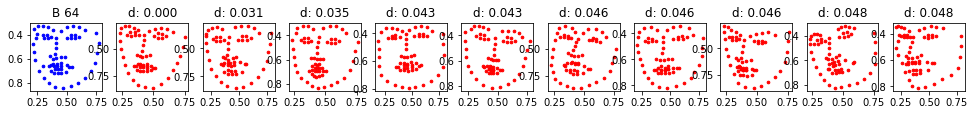

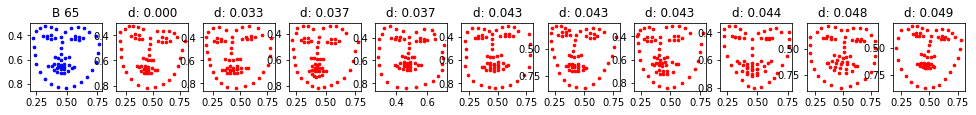

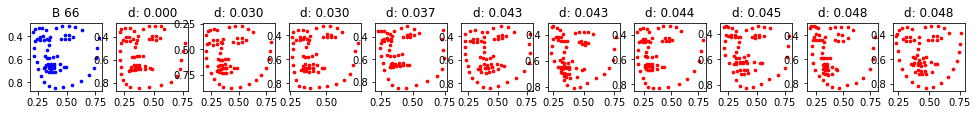

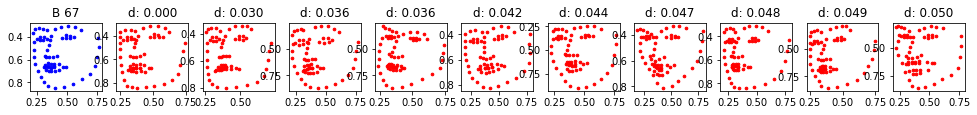

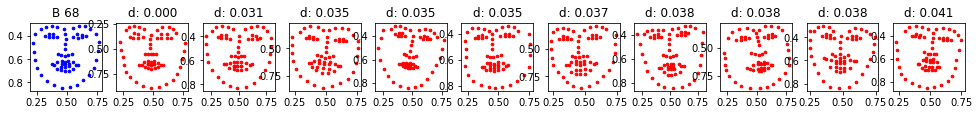

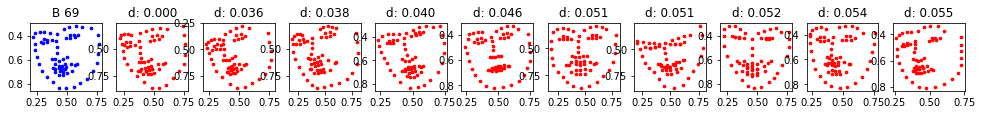

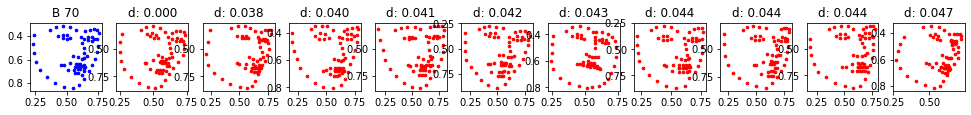

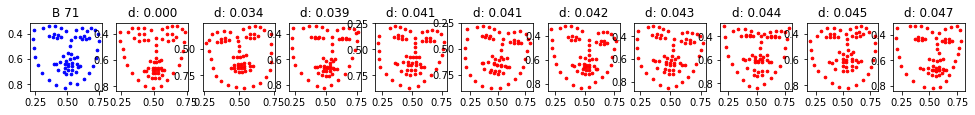

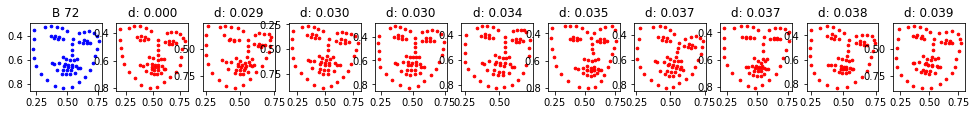

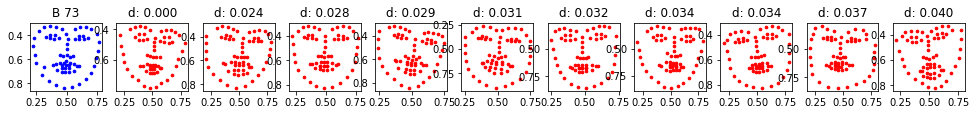

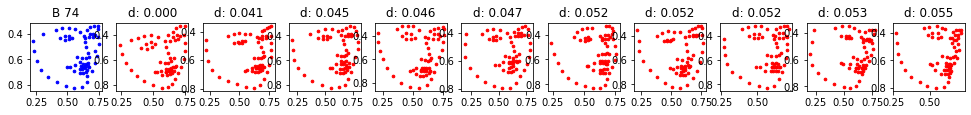

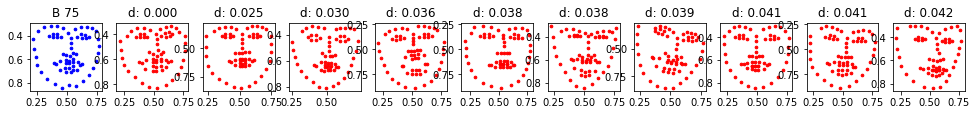

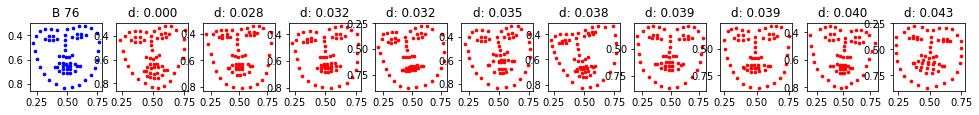

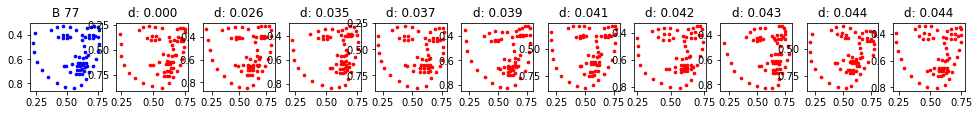

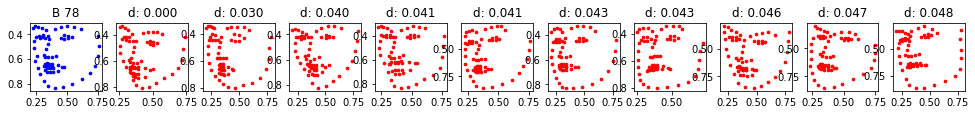

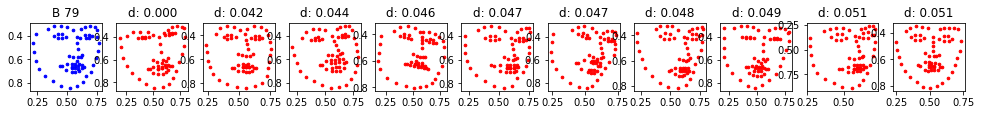

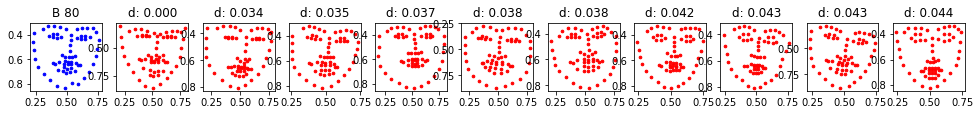

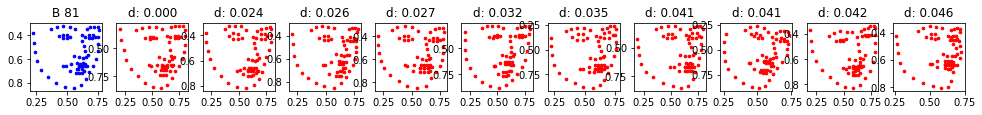

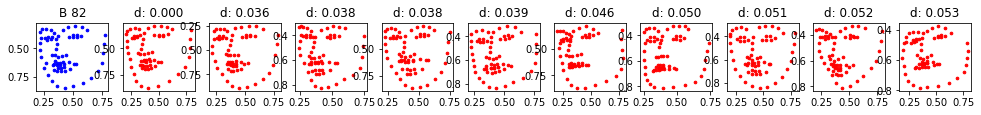

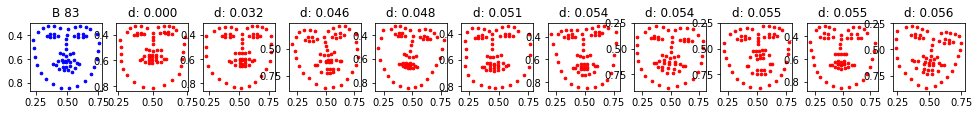

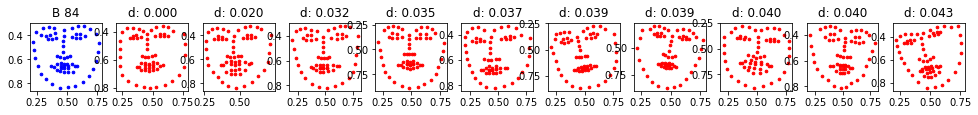

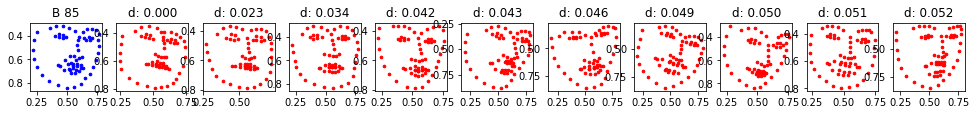

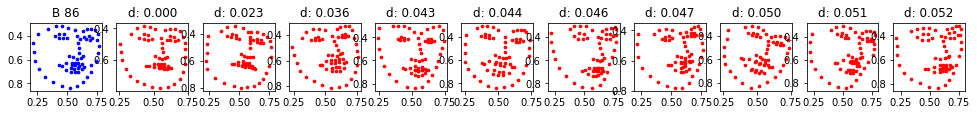

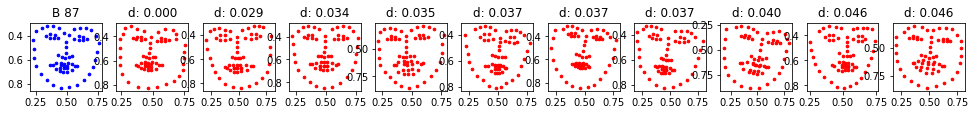

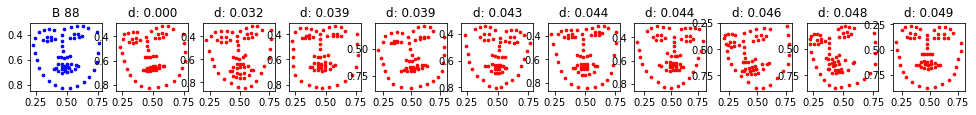

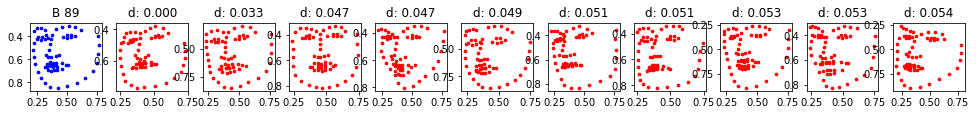

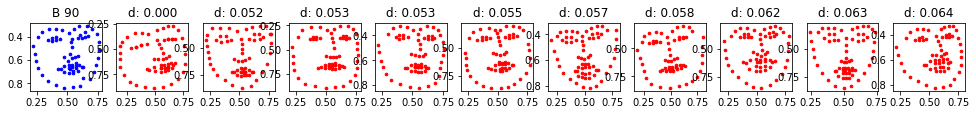

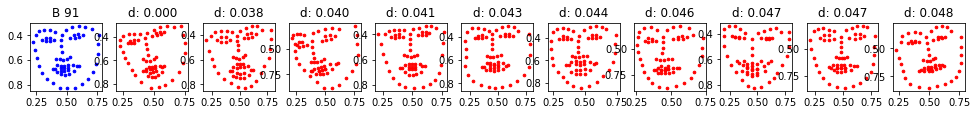

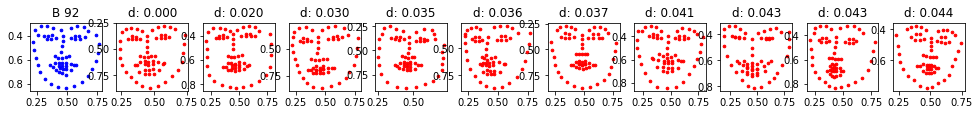

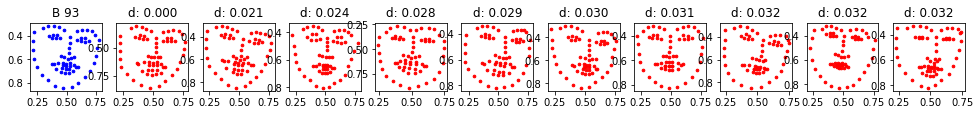

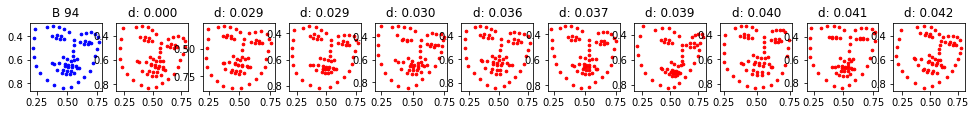

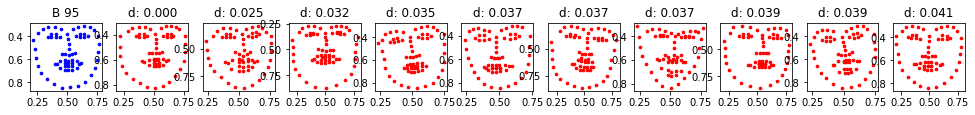

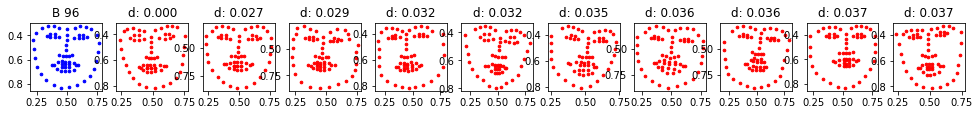

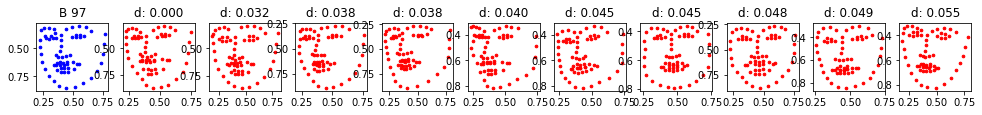

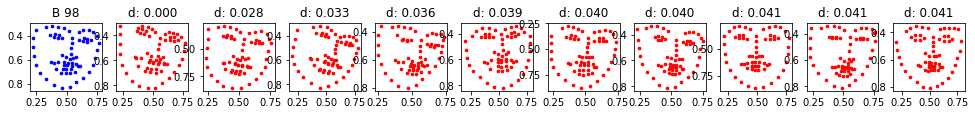

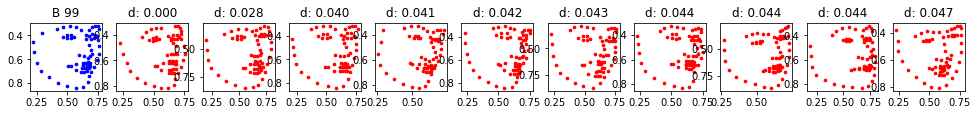

In [53]:
for ii, idx in enumerate(indices):
    B = ot.lp.free_support_barycenter([
        LS(idx[0]), LS(idx[1]), 
        LS(idx[2]), LS(idx[3]), 
        LS(idx[4]), LS(idx[5]), 
        LS(idx[6]), LS(idx[7]), 
        LS(idx[8]), LS(idx[9])
    ], 
    [a] * 10,
    X_init, a
    )
    
    fig, ax = plt.subplots(nrows=1, ncols=11, figsize=(16.75,1.25))
    
    for k in range(10):
        ax[k+1].invert_yaxis()
        ax[k+1].set_title("d: {:.3f}".format(distances[ii][k]))
        ax[k+1].scatter(LS(idx[k])[:,0], LS(idx[k])[:,1], c="r", s=7)
    
    ax[0].invert_yaxis()
    ax[0].set_title("B {}".format(ii))
    ax[0].scatter(B[:,0], B[:,1], c="b", s=7)
    
    plt.show()

(array([ 198., 2336., 2762., 1942., 1220.,  736.,  434.,  248.,   88.,
          36.]),
 array([0.        , 0.03066459, 0.06132918, 0.09199378, 0.12265837,
        0.15332296, 0.18398755, 0.21465214, 0.24531674, 0.27598133,
        0.30664592]),
 <a list of 10 Patch objects>)

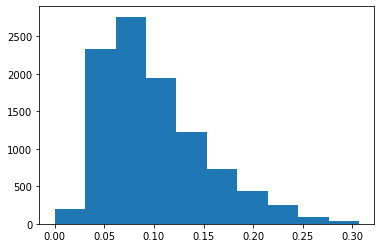

In [55]:
plt.hist(D.reshape(-1))

In [56]:
import pandas as pd
import networkx as nx

In [57]:
def threshold(A, eps=0.3):
    B = A.copy()
    B = (B < eps).astype(int)
    np.fill_diagonal(B, 0)
    return B

def knn(A, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, metric="precomputed").fit(A)
    K = nbrs.kneighbors_graph(A).toarray().astype(int)
    np.fill_diagonal(K, 0)
    return K + K.T

In [58]:
def _knn(A, k=3):
    B = A.copy()

    for i, _ in enumerate(B):
        knn_dist_i = np.sort(B[i])[k-1]
        B[i] = (B[i] <= knn_dist_i).astype(int)

    np.fill_diagonal(B, 0)
    return B + B.T

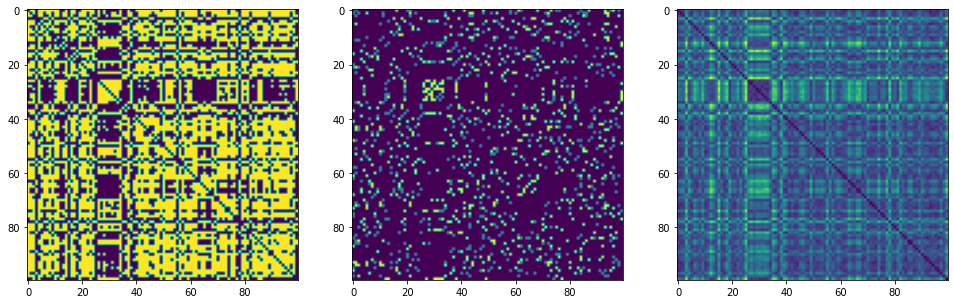

In [63]:
A = threshold(D, 0.1)
K = knn(D, 10)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16.5,5.5))
ax[0].imshow(A)
ax[1].imshow(K)
ax[2].imshow(D)
plt.show()

In [64]:
G = nx.from_numpy_array(K)

In [65]:
simplices = []

min_clique, max_clique = 2, 20

cliques = nx.find_cliques(G)
max_clique_size = 0

for clique in cliques:
    if (len(clique) >= min_clique) & (len(clique) <= max_clique):
        simplices.append(clique)
        
        if len(clique) > max_clique_size:
            max_clique_size = len(clique)
        
len(simplices), max_clique_size

(325, 7)

In [66]:
simplices

[[0, 96, 48, 73, 84],
 [0, 96, 48, 73, 76],
 [0, 96, 48, 73, 93],
 [0, 96, 48, 73, 87],
 [0, 96, 48, 61, 16, 93],
 [0, 96, 48, 61, 62, 84],
 [0, 96, 48, 61, 62, 93],
 [0, 96, 48, 61, 62, 87],
 [0, 96, 48, 76, 37],
 [0, 96, 58, 76, 37],
 [0, 96, 20, 37],
 [0, 96, 95, 16],
 [0, 96, 95, 37],
 [0, 1, 48, 93],
 [0, 1, 58],
 [0, 1, 21],
 [0, 98, 93, 75],
 [0, 98, 93, 61],
 [0, 98, 21],
 [0, 68, 48, 61, 16],
 [0, 68, 48, 61, 84, 62],
 [0, 68, 48, 37],
 [0, 68, 20, 37],
 [0, 41, 73, 76],
 [0, 41, 73, 93],
 [0, 41, 75, 93],
 [0, 41, 75, 95],
 [0, 41, 37, 58, 76],
 [0, 41, 37, 20],
 [0, 41, 37, 95],
 [0, 21, 16],
 [0, 21, 87],
 [3, 18, 66, 67, 78],
 [3, 18, 66, 67, 63, 15],
 [3, 18, 66, 39, 25, 78],
 [3, 18, 66, 39, 25, 15],
 [3, 18, 66, 39, 63, 15],
 [3, 18, 35, 67, 78, 55],
 [3, 18, 35, 67, 63, 55],
 [3, 18, 35, 67, 63, 15],
 [3, 18, 35, 39, 55, 25, 78],
 [3, 18, 35, 39, 55, 63],
 [3, 18, 35, 39, 15, 25],
 [3, 18, 35, 39, 15, 63],
 [4, 13, 49, 77],
 [4, 13, 49, 31],
 [4, 19, 81, 77, 49, 28],
 

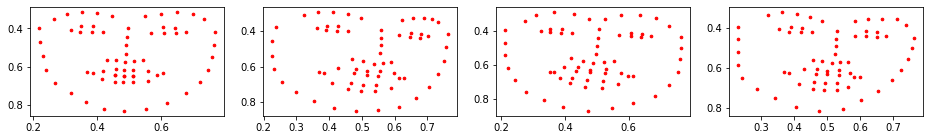

In [113]:
i = 13
fig, ax = plt.subplots(nrows=1, ncols=len(simplices[i]), figsize=(16,2))
for k in range(len(simplices[i])):
    ax[k].invert_yaxis()
    ax[k].scatter(LS(simplices[i][k])[:,0], LS(simplices[i][k])[:,1], c="r", s=7)
plt.show()

In [13]:
def test(encoder):
    sum_loss = 0
#     was_loss = 0
    for i, batch in enumerate(LazyLoader.w300().test_loader):
        data = batch['data'].to(device)
        landmarks = batch["meta"]["keypts_normalized"].cuda()
        landmarks[landmarks > 1] = 0.99999
        print(landmarks.max())
        content = heatmap_to_measure(encoder(data))[0]
        pred_measure = UniformMeasure2DFactory.from_heatmap(encoder(data))
        target = UniformMeasure2D01(torch.clamp(landmarks, max=1))
        eye_dist = landmarks[:, 45] - landmarks[:, 36]
        eye_dist = eye_dist.pow(2).sum(dim=1).sqrt()
        sum_loss += (handmadew1(pred_measure, target) / eye_dist).sum().item()
    return sum_loss / len(LazyLoader.w300().test_dataset)

In [83]:
w300_test = next(iter(LazyLoader.w300().test_loader))
w300_test_image = w300_test['data'].to(device)[:8]
w300_test_mask = ProbabilityMeasureFabric(256).from_coord_tensor(w300_test["meta"]["keypts_normalized"][:8].to(device))
sparse_hm = heatmaper.forward(w300_test_mask.coord * 63).detach()


300 W initialize
train size: 3148, test size: 689


In [84]:
sparse_hm.shape

torch.Size([1, 68, 64, 64])

In [15]:
from torchvision.utils import make_grid
from gan.gan_model import CondGen3, CondDisc3, CondStyleGanModel
from model import Generator

In [16]:
latent = 512
n_mlp = 5
size = 256
latent_size = 512
encoder_HG = HG_softmax2020(num_classes=68, heatmap_size=64)
generator = CondGen3(Generator(
    size, latent, n_mlp, channel_multiplier=1
))

weights = torch.load(
        "/raid/data/saved_models/stylegan2_new_150000.pt",
        map_location="cpu"
    )
print(weights.keys())
generator.load_state_dict(weights['g'])
generator = generator.cuda()
encoder_HG.load_state_dict(weights['c'])
encoder_HG = encoder_HG.cuda()

dict_keys(['g', 'd', 'c', 's'])


In [21]:
transform = albumentations.Compose(
        [
            albumentations.Resize(256, 256),
            albumentations.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            AlbToTensor()
        ]
    )

dataset = ImageMeasureDataset(
    "/raid/data/celeba",
    "/raid/data/celeba_masks",
    img_transform=transform
)

loader = data.DataLoader(
    dataset,
    batch_size=1,
    sampler=data_sampler(dataset, shuffle=False, distributed=False),
    drop_last=True,
)

In [22]:
loader = sample_data(loader)
test_img, test_mask = next(loader)
plt.imshow((test_img[0].permute(1,2,0).cpu().numpy() + 1) / 2)

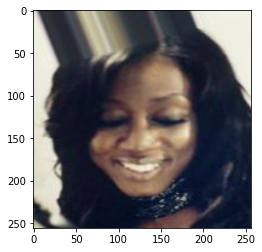

In [28]:
plt.imshow((test_img[0].permute(1,2,0).cpu().numpy() + 1) / 2)

In [29]:
device = "cuda:3"
test_img, test_mask = next(loader)
test_img = test_img.cuda()
test_mask = test_mask.cuda()
import random
batch_size=1
batch=1
noise1 = mixing_noise(1, latent_size, 0.9, device)
with torch.no_grad():
    content_test = encoder_HG(test_img)
    print(content_test.shape)
    pred_measures = UniformMeasure2DFactory.from_heatmap(content_test)
    sparce_hm = heatmaper.forward(pred_measures.coord * 63).detach()
    generator_output = generator.forward(sparce_hm, noise1)

torch.Size([1, 68, 64, 64])


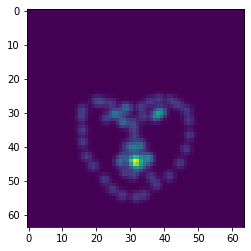

In [30]:
plt.imshow(sparce_hm[0].sum(0).detach().cpu().numpy())
plt.show()

In [65]:
device = "cuda:3"
import random
batch_size=2
noise1 = mixing_noise(batch_size, latent_size, 0.9, device)
with torch.no_grad():
    content_test = encoder_HG(w300_test_image)
    pred_measures = UniformMeasure2DFactory.from_heatmap(content_test)
    sparce_hm = heatmaper.forward(pred_measures.coord * 63).detach()
    generator_output = generator.forward(sparse_hm, noise1)

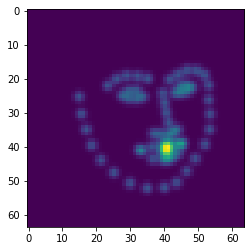

In [66]:
plt.imshow(sparse_hm[0].sum(0).detach().cpu().numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


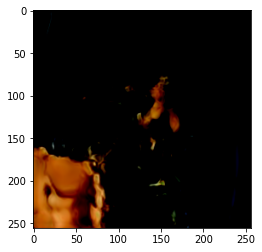

In [67]:
plt.imshow(generator_output[0][0].permute(1,2,0).detach().cpu().numpy())
plt.show()

In [ ]:
test_images = w300_test_image.cuda()
HG = encoder_HG(test_images)

In [20]:
test_images = w300_test_image.cuda()

In [21]:
HG = encoder_HG(test_images)

In [22]:
with torch.no_grad():
    print(test(encoder_HG))

tensor(0.9057, device='cuda:2')
RAVNOMERNAYA MERA tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.8662e-38, 1.4641e-41,
         1.1351e-43],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.6171e-04, 1.7723e-03,
         2.7234e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [6.4599e-13, 2.2949e-20, 3.0617e-32,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.8851e-08, 1.8402e-09,
         1.1856e-10],
        [1.3545e-35, 6.7061e-18, 1.0413e-07,  ..., 0.0000e+00, 0.0000e+00,
         9.2065e-43]], device='cuda:2')
L2 cherez PAIRWISE:  tensor(0.5163, device='cuda:2')
L2 v ruchnuu:  tensor(0.5163, device='cuda:2')
tensor(0.9002, device='cuda:2')
RAVNOMERNAYA MERA tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.2078e-35, 8.2044e-38,
         2.4894e-41],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.6850e-04, 1.4543e-03,
         2.9345

RAVNOMERNAYA MERA tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.1410e-05, 2.5966e-03,
         3.8889e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [4.2232e-11, 1.1920e-20, 1.0869e-33,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.7813e-11, 2.6279e-13,
         4.7572e-16],
        [2.7202e-22, 6.9816e-11, 5.7334e-05,  ..., 0.0000e+00, 4.9476e-40,
         7.2284e-30]], device='cuda:2')
L2 cherez PAIRWISE:  tensor(0.5206, device='cuda:2')
L2 v ruchnuu:  tensor(0.5206, device='cuda:2')
tensor(0.9108, device='cuda:2')
RAVNOMERNAYA MERA tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.8026e-45,  ..., 5.1633e-05, 1.9238e-03,
         3.5038e-03],
        [0.0000e+00, 0.00

RAVNOMERNAYA MERA tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.4013e-45, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.8005e-36,  ..., 1.1848e-04, 1.9914e-03,
         3.3062e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.1728e-05, 9.3117e-10, 1.8252e-20,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 2.8026e-45, 4.3952e-39,  ..., 7.3856e-10, 8.6114e-11,
         2.5801e-11],
        [9.9159e-27, 3.4186e-15, 6.1839e-07,  ..., 2.3341e-35, 1.3541e-25,
         2.3964e-18]], device='cuda:2')
L2 cherez PAIRWISE:  tensor(0.5262, device='cuda:2')
L2 v ruchnuu:  tensor(0.5262, device='cuda:2')
tensor(0.9330, device='cuda:2')
RAVNOMERNAYA MERA tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0998e-16, 3.0749e-20,
         4.8269e-22],
        [0.0000e+00, 0.0000e+00, 9.9368e-36,  ..., 4.3677e-04, 2.4242e-03,
         2.5983e-03],
        [0.0000e+00, 0.00

RAVNOMERNAYA MERA tensor([[1.2402e-36, 1.8461e-40, 1.9197e-36,  ..., 2.8026e-45, 1.4013e-45,
         1.4013e-45],
        [0.0000e+00, 4.6098e-31, 1.1918e-16,  ..., 9.7172e-05, 1.0746e-03,
         2.2148e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [6.9045e-10, 3.6582e-23, 5.1981e-34,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.3502e-39, 1.5676e-29, 7.1076e-18,  ..., 8.0501e-10, 6.4756e-10,
         4.1282e-10],
        [7.6632e-21, 1.4145e-08, 4.6845e-03,  ..., 9.3779e-26, 1.2955e-18,
         4.9735e-14]], device='cuda:2')
L2 cherez PAIRWISE:  tensor(0.5063, device='cuda:2')
L2 v ruchnuu:  tensor(0.5063, device='cuda:2')
tensor(0.9568, device='cuda:2')
RAVNOMERNAYA MERA tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0651e-41, 2.8026e-45,
         1.4013e-45],
        [0.0000e+00, 0.0000e+00, 3.9089e-36,  ..., 3.7879e-05, 1.4299e-03,
         3.0228e-03],
        [0.0000e+00, 0.00

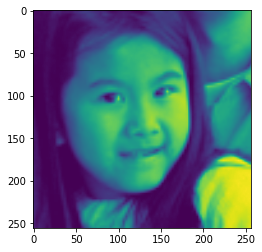

In [12]:
plt.imshow(test_images[0].sum(0).detach().cpu().numpy())
plt.show()

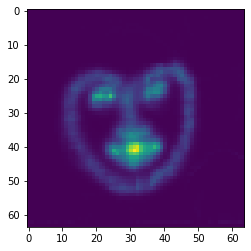

In [13]:
plt.imshow(HG[0].sum(0).detach().cpu().numpy())
plt.show()

In [106]:
res = imgs_with_mask(w300_test_image, w300_test_mask.toImage(256))

In [107]:
grid = make_grid(
            res[0:4], nrow=2, padding=2, pad_value=0, normalize=True, range=(-1, 1),
            scale_each=False)

In [108]:
grid_transpose = grid.permute(1,2,0)

In [109]:
w300_test_image_numpy = grid_transpose.cpu().numpy()

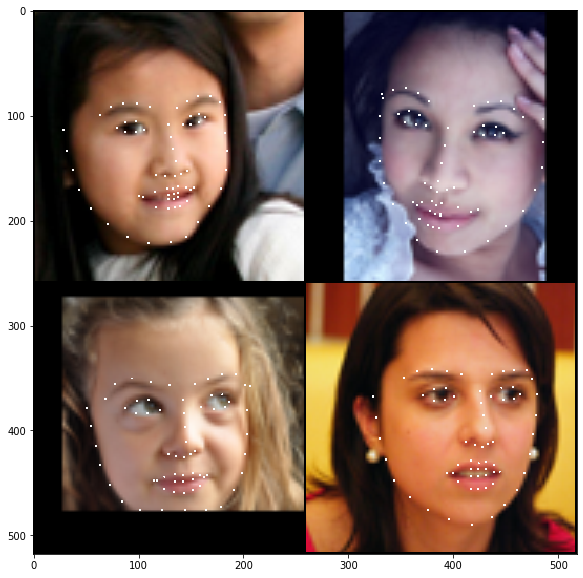

In [110]:
from matplotlib import pyplot as plt

plt.figure(figsize = (40,10))
plt.imshow(w300_test_image_numpy, interpolation='nearest')

In [111]:
res_transformed = g_transforms(image=w300_test_image, mask=w300_test_mask)
transformed_image, transformed_mask = res_transformed['image'], res_transformed['mask']
transformed_res = imgs_with_mask(transformed_image, transformed_mask.toImage(256))

In [112]:
grid = make_grid(
            transformed_res[0:4], nrow=2, padding=2, pad_value=0, normalize=True, range=(-1, 1),
            scale_each=False)

In [113]:
grid_transpose = grid.permute(1,2,0)

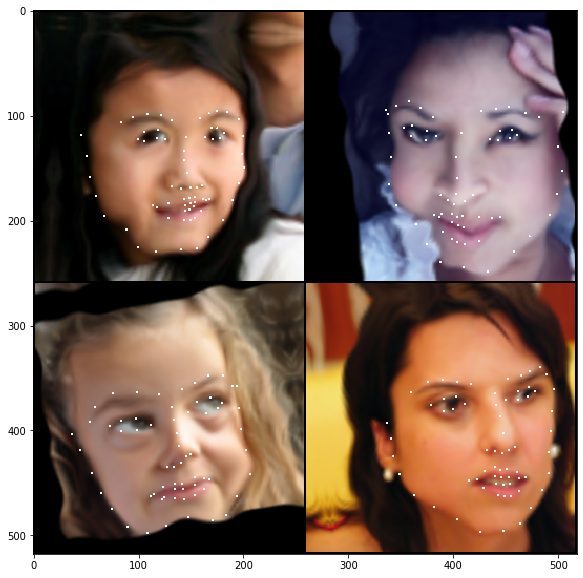

In [114]:
w300_test_image_numpy = grid_transpose.cpu().numpy()
plt.figure(figsize = (40,10))
plt.imshow(w300_test_image_numpy, interpolation='nearest')

In [115]:
heatmaper = ToHeatMap(64)

In [136]:
import math

def final_preds_untransformed(output, res):
    coords = get_preds(output) # float type

    # pose-processing
    for n in range(coords.size(0)):
        for p in range(coords.size(1)):
            hm = output[n][p]
            px = int(math.floor(coords[n][p][0]))
            py = int(math.floor(coords[n][p][1]))
            if px > 1 and px < res[0] and py > 1 and py < res[1]:
                diff = torch.tensor([hm[py - 1][px] - hm[py - 1][px - 2], hm[py][px - 1]-hm[py - 2][px - 1]], device=output.device)
                coords[n][p] += diff.sign() * .25
    coords += 0.5

    if coords.dim() < 3:
        coords = coords.unsqueeze(0)

    coords -= 1  # Convert from 1-based to 0-based coordinates

    return coords


def get_preds(scores):
    ''' get predictions from score maps in torch Tensor
        return type: torch.LongTensor
    '''
    assert scores.dim() == 4, 'Score maps should be 4-dim'
    maxval, idx = torch.max(scores.view(scores.size(0), scores.size(1), -1), 2)

    maxval = maxval.view(scores.size(0), scores.size(1), 1)
    idx = idx.view(scores.size(0), scores.size(1), 1) + 1

    preds = idx.repeat(1, 1, 2).float()

    preds[:,:,0] = (preds[:,:,0] - 1) % scores.size(3) + 1
    preds[:,:,1] = torch.floor((preds[:,:,1] - 1) / scores.size(3)) + 1

    pred_mask = maxval.gt(0).repeat(1, 1, 2).float()
    preds *= pred_mask
    return preds

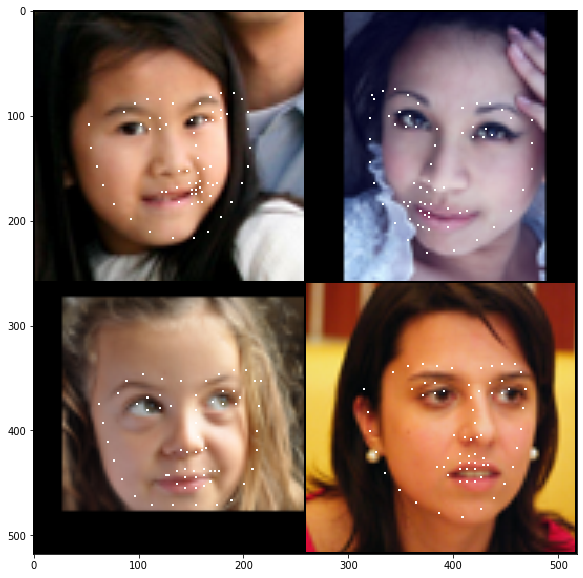

In [138]:
w300_test = next(iter(LazyLoader.w300().test_loader))
w300_test_mask = ProbabilityMeasureFabric(256).from_coord_tensor(w300_test["meta"]["keypts_normalized"][:8].to(device))
w300_test_mask = heatmaper.forward(w300_test_mask.probability, w300_test_mask.coord * 63)

coord = final_preds_untransformed(w300_test_mask, (64, 64)) / 64
coord = coord.cuda()
prob = torch.ones(8, 68) / 68
prob = prob.cuda()
maskkk = ProbabilityMeasure(prob, coord)
transformed_res = imgs_with_mask(w300_test_image, maskkk.toImage(256))
grid = make_grid(
            transformed_res[0:4], nrow=2, padding=2, pad_value=0, normalize=True, range=(-1, 1),
            scale_each=False)
grid_transpose = grid.permute(1,2,0)

w300_test_image_numpy = grid_transpose.cpu().numpy()
plt.figure(figsize = (40,10))
plt.imshow(w300_test_image_numpy, interpolation='nearest')


In [117]:
class NormalizeMask(albumentations.DualTransform):
    def __init__(self, dim):
        super(NormalizeMask, self).__init__(1)
        self.dim = dim

    def apply(self, img: torch.Tensor, **params):
        return img

    def apply_to_mask(self, img: torch.Tensor, **params):
        img = np.array(img)
        img[img<0]=0
        img = img / (img.sum(axis=self.dim, keepdims=True) + 1e-10)
        return img

In [118]:
g_transforms: albumentations.DualTransform = albumentations.Compose([
        ToNumpy(),
        NumpyBatch(ResizeMask(h=256, w=256)),
        NumpyBatch(albumentations.ElasticTransform(p=1, alpha=150, alpha_affine=1, sigma=10)),
        NumpyBatch(albumentations.ShiftScaleRotate(p=1, rotate_limit=10)),
        NumpyBatch(ResizeMask(h=64, w=64)),
        NumpyBatch(NormalizeMask(dim=(0,1,2))),
        ToTensor(device),
#         MaskToMeasure(size=256, padding=140, clu),
    ])

In [119]:
res_transformed = g_transforms(image=w300_test_image, mask=w300_test_mask)
transformed_image, transformed_mask = res_transformed['image'], res_transformed['mask']
# transformed_res = imgs_with_mask(transformed_image, transformed_mask.toImage(256))

In [126]:
coord, prob = heatmap_to_measure(w300_test_mask)
mes_mask = ProbabilityMeasure(prob, coord)

In [127]:
prob.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:3')

In [128]:
transformed_res = imgs_with_mask(transformed_image, mes_mask.toImage(256))


In [129]:
grid = make_grid(
            transformed_res[0:4], nrow=2, padding=2, pad_value=0, normalize=True, range=(-1, 1),
            scale_each=False)
grid_transpose = grid.permute(1,2,0)

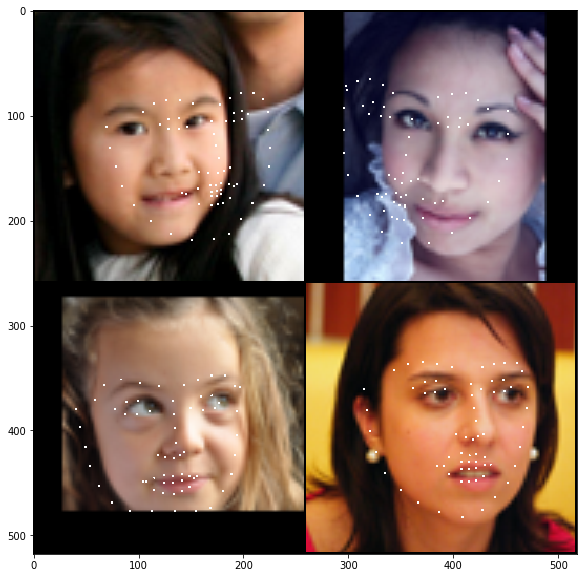

In [131]:
w300_test_image_numpy = grid_transpose.cpu().numpy()
plt.figure(figsize = (40,10))
plt.imshow(w300_test_image_numpy, interpolation='nearest')

In [11]:
import random

In [12]:
def data_sampler(dataset, shuffle, distributed):
    if distributed:
        return data.distributed.DistributedSampler(dataset, shuffle=shuffle)

    if shuffle:
        return data.RandomSampler(dataset)

    else:
        return data.SequentialSampler(dataset)
    
def sample_data(loader):
    while True:
        for batch in loader:
            yield batch

def content_to_measure(content):
    batch_size = content.shape[0]
    pred_measures: ProbabilityMeasure = ProbabilityMeasure(
            torch.ones(batch_size, 70, device=device) / 70,
            content.reshape(batch_size, 70, 2)
        )
    return pred_measures

def imgs_with_mask(imgs, mask, color=[1.0,1.0,1.0]):
    # mask = torch.cat([mask, mask, mask], dim=1)
    mask = mask[:, 0, :, :]
    res: Tensor = imgs.cpu().detach()
    res = res.permute(0, 2, 3, 1)
    res[mask > 0.00001, :] = torch.tensor(color, dtype=torch.float32)
    res = res.permute(0, 3, 1, 2)

    return res

def make_noise(batch, latent_dim, n_noise, device):
    if n_noise == 1:
        return torch.randn(batch, latent_dim, device=device)

    noises = torch.randn(n_noise, batch, latent_dim, device=device).unbind(0)

    return noises

def mixing_noise(batch, latent_dim, prob, device):
    if prob > 0 and random.random() < prob:
        return make_noise(batch, latent_dim, 2, device)

    else:
        return [make_noise(batch, latent_dim, 1, device)]



In [13]:
class Args:
    iter = 800000
    batch = 8
    n_sample = 64
    size = 256
    r1 = 10
    path_regularize = 2
    path_batch_shrink = 2
    d_reg_every = 16
    g_reg_every = 4
    mixing = 0.9
    ckpt = None
    lr = 0.002
    channel_multiplier = 1
    wandb = 'store_true'
    local_rank = 0
    image_size = 256
    batch_size = 1
    measure_size = 70 
    ct = 0.0001
    ca = 0.0002
    cw = 0.002
    ngf = 64
    ndf = 64 
    L1 = 2
    noise_size = 256.0
    input_dim = 3 
    dim = 16
    style_dim = 512 
    n_downsample = 2
    n_res = 4 
    activ = 'lrelu'
    pad_type = 'replicate'
    norm = 'none'
    mlp_dim = 256
    n_layer = 8
    num_scales = 1
    

munit_args=Args()
args = Args()

In [14]:
cont_style_encoder: MunitEncoder = cont_style_munit_enc(
        munit_args,
        None, # "/home/ibespalov/pomoika/munit_content_encoder15.pt",
        None  # "/home/ibespalov/pomoika/munit_style_encoder_1.pt"
    )

In [13]:
import torch
device = "cuda:3"
starting_model_number = 340000 
# weights = torch.load(f"/home/ibespalov/pomoika/stylegan2_invertable_{starting_model_number}.pt", map_location="cpu")
weights = torch.load(f"/home/ibespalov/pomoika/stylegan2_igor_2.pt", map_location="cpu")
print(weights.keys())
cont_style_encoder.load_state_dict(weights['enc'])
cont_style_encoder = cont_style_encoder.to(device)

dict_keys(['g', 'd', 'enc'])


In [44]:
transform = albumentations.Compose(
        [
            albumentations.Resize(munit_args.size, munit_args.size),
            albumentations.ShiftScaleRotate(p=1, rotate_limit=10),
            albumentations.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            AlbToTensor()
        ]
    )

    # dataset = ImageFolder("/raid/data/celeba", transform=transform)

dataset = ImageMeasureDataset(
    "/raid/data/celeba",
    "/raid/data/celeba_masks",
    img_transform=transform
)

loader = data.DataLoader(
    dataset,
    batch_size=1,
    sampler=data_sampler(dataset, shuffle=False, distributed=False),
    drop_last=True,
)

In [15]:
loader = sample_data(loader)
test_img, test_mask = next(loader)
test_img = test_img.cuda()
test_mask = test_mask.cuda()
for_gen_content = cont_style_encoder.get_content(test_img)
print(test_img.shape)
print(for_gen_content.shape)
images_repeated = for_gen_content.repeat(8,1) 
print(images_repeated)

torch.Size([1, 3, 256, 256])
torch.Size([1, 140])
tensor([[0.4247, 0.5363, 0.3205,  ..., 0.5362, 0.4285, 0.8107],
        [0.4247, 0.5363, 0.3205,  ..., 0.5362, 0.4285, 0.8107],
        [0.4247, 0.5363, 0.3205,  ..., 0.5362, 0.4285, 0.8107],
        ...,
        [0.4247, 0.5363, 0.3205,  ..., 0.5362, 0.4285, 0.8107],
        [0.4247, 0.5363, 0.3205,  ..., 0.5362, 0.4285, 0.8107],
        [0.4247, 0.5363, 0.3205,  ..., 0.5362, 0.4285, 0.8107]],
       device='cuda:3', grad_fn=<RepeatBackward>)


In [17]:
from gan.gan_model import CondStyleDisc2Wrapper, cont_style_munit_enc, CondStyleGanModel, CondGen2
from stylegan2.stariy_gan import Generator
args.latent = 512
args.n_mlp = 5
args.size = 256
args.batch = 1

args.start_iter = 0

generator = CondGen2(Generator(
    args.size, args.latent, args.n_mlp, channel_multiplier=args.channel_multiplier
))
generator.load_state_dict(weights['g'])
generator = generator.to(device)
with torch.no_grad():
    noise1 = mixing_noise(args.batch, args.latent, args.mixing, device)
    fake1, _ = generator(for_gen_content, noise1)

In [18]:
fake1.shape

torch.Size([1, 3, 256, 256])

In [24]:
content.shape

torch.Size([1, 140])

In [18]:
images_repeated = for_gen_content.repeat(8,1) 
images_repeated.shape
# images_repeated = images_repeated.view(-1,input_size, sequence_length)

torch.Size([8, 140])

In [17]:
for_gen_content = cont_style_encoder.get_content(test_img)
for_gen_content

tensor([[0.4247, 0.5363, 0.3205, 0.7376, 0.4996, 0.6848, 0.5294, 0.6460, 0.3707,
         0.5341, 0.4683, 0.6442, 0.4190, 0.4810, 0.4962, 0.6109, 0.7301, 0.6000,
         0.5290, 0.6452, 0.5569, 0.4793, 0.4693, 0.7284, 0.4976, 0.6885, 0.6200,
         0.5172, 0.4351, 0.7005, 0.4249, 0.7020, 0.3952, 0.7945, 0.7208, 0.6445,
         0.3044, 0.6954, 0.5706, 0.5264, 0.4960, 0.6867, 0.2682, 0.5152, 0.5087,
         0.7304, 0.7374, 0.5506, 0.6523, 0.4634, 0.5138, 0.5275, 0.5779, 0.7032,
         0.3766, 0.5410, 0.4146, 0.5379, 0.6857, 0.7260, 0.5716, 0.5224, 0.3602,
         0.7686, 0.4679, 0.5450, 0.5740, 0.8078, 0.4622, 0.7271, 0.3749, 0.5314,
         0.4907, 0.6847, 0.6189, 0.5183, 0.4796, 0.6438, 0.4693, 0.6466, 0.4248,
         0.7018, 0.4934, 0.6866, 0.4988, 0.6859, 0.5152, 0.7286, 0.4982, 0.5774,
         0.6105, 0.7847, 0.3328, 0.4777, 0.6182, 0.5191, 0.5770, 0.5297, 0.6823,
         0.4735, 0.3318, 0.4854, 0.7377, 0.4958, 0.2741, 0.6137, 0.6496, 0.7576,
         0.5095, 0.7267, 0.5

In [200]:
fake1 = fake1[0]

In [203]:
fake1.shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


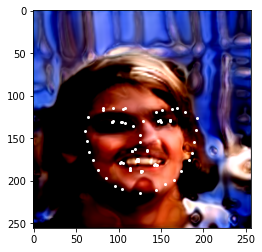

In [22]:
plt.imshow(fake1.detach().cpu().numpy()[0].transpose(1,2,0))
plt.scatter(x, y, s=4, marker='o', c='w')

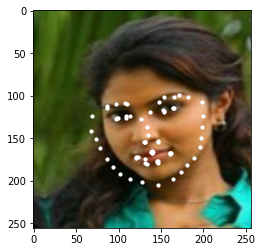

In [156]:
loader = sample_data(loader)
test_img, test_mask = next(loader)
test_img = test_img.cuda()
test_mask = test_mask.cuda()
content, latent = cont_style_encoder(test_img)
test_img = (test_img + 1) / 2
pred_measures: ProbabilityMeasure = content_to_measure(content)
x = np.around((pred_measures.coord[0,:,0] * 256).detach().cpu().numpy())
y = np.around((pred_measures.coord[0,:,1] * 256).detach().cpu().numpy())
plt.imshow(test_img.detach().cpu().numpy()[0].transpose(1,2,0))
plt.scatter(x, y, s=10, marker='o', c='w')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


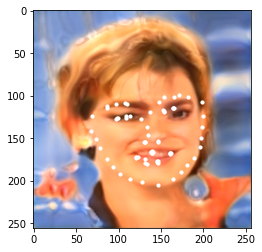

In [161]:
images_repeated = content
noise1 = mixing_noise(args.batch, args.latent, args.mixing, device)
fake1, _ = generator(images_repeated, noise1)
plt.imshow(((fake1.detach().cpu().numpy()[0] + 1) / 2).transpose(1,2,0))
plt.scatter(x, y, s=10, marker='o', c='w')

In [213]:
fake1[0].max()

tensor(1.1482, device='cuda:2', grad_fn=<MaxBackward1>)

In [146]:
test_img.max()

tensor(1., device='cuda:2')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


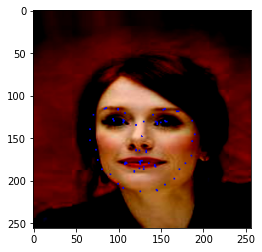

In [121]:
iwm = imgs_with_mask(test_img, pred_measures.toImage(256), color=[0, 0, 1])
iwm = iwm.numpy()[0].transpose(1,2,0)
plt.imshow(iwm)